# Import

In [1]:
from pandas import read_csv, DataFrame
from scipy.stats import pearsonr, f
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score
from numpy import array, mean, append, unique
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from os import makedirs
from IPython.display import display, Markdown
from statsmodels.formula.api import glm
from math import ceil, floor, sqrt
from pingouin import anova, cronbach_alpha, pairwise_corr, linear_regression, corr
from xgboost import XGBRegressor
from dalex import Explainer
from warnings import filterwarnings
filterwarnings('ignore')

# Setup
## Load data and setup output dir

In [2]:
data = read_csv("data/anon.csv", sep="\t")
makedirs("output", exist_ok=True)

## Factoring categorical data

In [3]:
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

data["hand_number"] = data["hand"].map({
    "Right-handed": 0,
    "Left-handed": 1
})

data["gamer_number"] = data["q9"].map({
    "A frequent video game player": 1,
    "An occasional video game player": 1,
    "A novice video game player": 0,
    "A non-video game player": 0
})

## Composite values

In [4]:
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["comp_average"] = data["comp_mg1"] + data["comp_gmd4"] + data["comp_co5"] + data["comp_co6"]

# Features and Labels

In [5]:
# What columns do we care about and what dependent variable col are we trying to predict?
features = [
    "total_events",
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    "n_puz_no_basic",
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    # "n_interm", # missing 15+%
    # "n_adv", # missing over 30 values
    "total_active",
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    # "diff_event2", # missing 15+%
    # "diff_event3", # missing over 30 values
    "different_event",
    # "sbst", # dependent variable
    "gender_number",
    "hand_number",
    # "gamer_number", # missing 15+%
    "enjoyment",
    "comp_average",
    "comp_mg1",
    "comp_gmd4",
    "comp_co5",
    "comp_co6",
    # "sri" # dependent variable
]

labels = ["sbst", "sri"]
protecteds = ["gender_number", "hand_number"] #, "gamer_number"]
corr_extras = ["so", "mr", "sv"]
everything = features + labels + corr_extras

# Descriptive Stats

## Count missing values

In [6]:
for col in everything:
    num = data[col].isna().sum()
    percent = num / len(data) * 100
    print(f"Variable: {col:20} Count Non-Missing: {len(data)-num:<4} Count Missing: {num:<4} Percent Missing: {percent:.4}")

Variable: total_events         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_breaks         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_submit         Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_snapshot       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_view           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: total_manipulate     Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puzzle             Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: p_puz_no_basic       Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_complete           Count Non-Missing: 47   Count Missing: 0    Percent Missing: 0.0
Variable: n_tutorial           Count Non

## Histogram

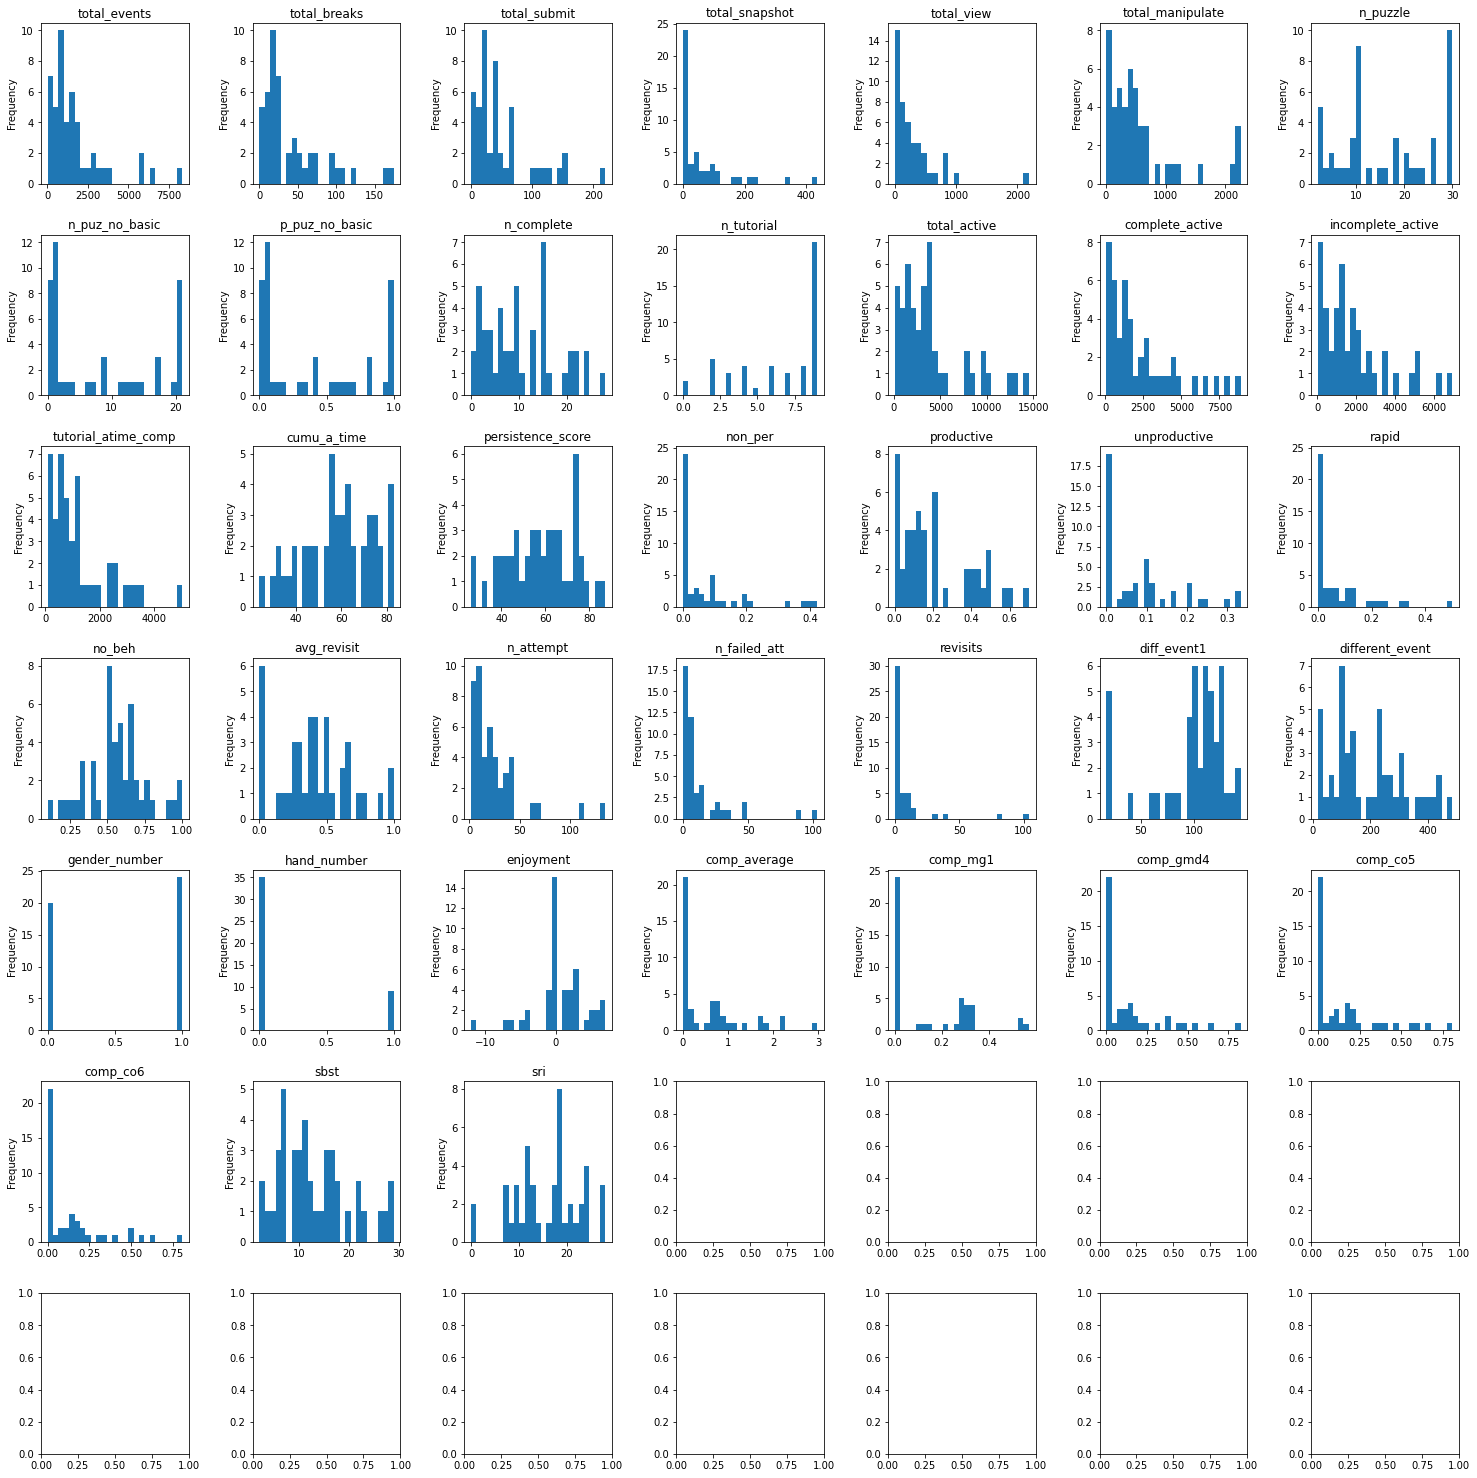

In [7]:
N = ceil(sqrt(len(features + labels)))
fig, axs = subplots(N, N)
fig.set_size_inches(3*N, 3*N)
fig.tight_layout(pad=3.0)
for i, col in enumerate(features + labels):
    data[col].plot(kind="hist", ax=axs[i//N][i%N], title=col, bins=25)

fig.savefig("output/hists.png")

## Percentages in binary categories

In [8]:
# gender
percent_female = len(data[data["gender_number"] == 1]) / len(data) * 100
print(f"Percent of students that are female: {percent_female:.4}")

# handedness
percent_left = len(data[data["hand_number"] == 1]) / len(data) * 100
print(f"Percent of students that are left-handed: {percent_left:.4}")

# handedness
percent_gamer = len(data[data["gamer_number"] == 1]) / len(data) * 100
print(f"Percent of students that are gamers: {percent_gamer:.4}")

Percent of students that are female: 51.06
Percent of students that are left-handed: 19.15
Percent of students that are gamers: 36.17


# Analysis

## Correlation

In [9]:
pw = pairwise_corr(data[features + labels + corr_extras])
pw.to_csv("output/corr.csv", sep="\t")
display(pw)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,total_events,total_breaks,pearson,two-sided,47,0.645940,"[0.44, 0.79]",9.422787e-07,2.084e+04,0.999264
1,total_events,total_submit,pearson,two-sided,47,0.831245,"[0.71, 0.9]",4.723115e-13,1.794e+10,1.000000
2,total_events,total_snapshot,pearson,two-sided,47,0.878537,"[0.79, 0.93]",4.868513e-16,1.23e+13,1.000000
3,total_events,total_view,pearson,two-sided,47,0.873332,"[0.78, 0.93]",1.182286e-15,5.292e+12,1.000000
4,total_events,total_manipulate,pearson,two-sided,47,0.969912,"[0.95, 0.98]",2.981582e-29,4.834e+25,1.000000
...,...,...,...,...,...,...,...,...,...,...
815,sri,mr,pearson,two-sided,44,0.891088,"[0.81, 0.94]",5.306859e-16,1.082e+13,1.000000
816,sri,sv,pearson,two-sided,44,0.865925,"[0.77, 0.93]",3.236657e-14,2.203e+11,1.000000
817,so,mr,pearson,two-sided,44,0.610590,"[0.38, 0.77]",1.076214e-05,2199.77,0.995703
818,so,sv,pearson,two-sided,44,0.617640,"[0.39, 0.77]",7.954919e-06,2907.53,0.996541


## Cronbach's Alpha

In [10]:
alpha, _ = cronbach_alpha(data=data[["so", "mr", "sv"]])
print(f"Cronbach's Alpha for SRI facets: {alpha}")

alpha, _ = cronbach_alpha(data=data[[f"sbst{i}" for i in range(1,31)]])
print(f"Cronbach's Alpha for SBST facets: {alpha}")

Cronbach's Alpha for SRI facets: 0.8359066056875625
Cronbach's Alpha for SBST facets: 0.8990425510278549


## ANOVA

In [11]:
# SRI and gender
aov = anova(data=data, dv="sri", between="gender")
print("ANOVA of sri between gender:")
display(aov)
print()

# SBST and gender
aov = anova(data=data, dv="sbst", between="gender")
print("ANOVA of sbst between gender:")
display(aov)
print()

# n_complete and gender
aov = anova(data=data, dv="n_complete", between="gender")
print("ANOVA of n_complete between gender:")
display(aov)
print()


# SRI and hand
aov = anova(data=data, dv="sri", between="hand_number")
print("ANOVA of sri between handedness:")
display(aov)
print()

# SBST and hand
aov = anova(data=data, dv="sbst", between="hand_number")
print("ANOVA of sbst between handedness:")
display(aov)
print()

# n_complete and hand
aov = anova(data=data, dv="n_complete", between="hand_number")
print("ANOVA of n_complete between handedness:")
display(aov)
print()


# SRI and gamer
aov = anova(data=data, dv="sri", between="gamer_number")
print("ANOVA of sri between gamerness:")
display(aov)
print()

# SBST and gamer
aov = anova(data=data, dv="sbst", between="gamer_number")
print("ANOVA of sbst between gamerness:")
display(aov)
print()

# n_complete and gamer
aov = anova(data=data, dv="n_complete", between="gamer_number")
print("ANOVA of n_complete between gamerness:")
display(aov)
print()

ANOVA of sri between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,1.777605,0.18963,0.040605



ANOVA of sbst between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,39,1.834019,0.183449,0.044914



ANOVA of n_complete between gender:


,Source,ddof1,ddof2,F,p-unc,np2
0,gender,1,42,0.614792,0.437389,0.014427



ANOVA of sri between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,42,0.536977,0.467758,0.012624



ANOVA of sbst between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,39,0.184474,0.66992,0.004708



ANOVA of n_complete between handedness:


,Source,ddof1,ddof2,F,p-unc,np2
0,hand_number,1,42,1.301829,0.260344,0.030064



ANOVA of sri between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,26,0.156389,0.695729,0.005979



ANOVA of sbst between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,27,0.303893,0.585985,0.01113



ANOVA of n_complete between gamerness:


,Source,ddof1,ddof2,F,p-unc,np2
0,gamer_number,1,27,1.672019,0.206943,0.058315


## Random Forest and XGB

### Helper

In [44]:
# specify the models
label_dict = {
    label: data[data[label] > 0][everything].dropna()
    for label in labels
}

model_dict = {
    "xgb": XGBRegressor(tree_method="hist", random_state=42),
    "rf": RandomForestRegressor(n_estimators=1000, random_state=42)
}

param_dict = { # TODO
    "xgb": {},
    "rf": {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
}

# Helper to run all the steps for a given dependent variable and regressor
def run_regressor(m, label, features, protecteds):
    
    # Heading
    display(Markdown(f"---\n\n# {m} {label}"))
    
    # Conventional Shorthand
    model = model_dict[m]
    subdata = label_dict[label]
    X = subdata[features]
    y = subdata[label]
    
    # Hyperparameter tuning
    parameters = param_dict[m]
    search = RandomizedSearchCV(model, parameters, scoring="r2", n_iter=200, cv=2, verbose=2, random_state=42, n_jobs=-1)
    search.fit(X, y)
    display(Markdown(f"**Hyperparameters:**"))
    display(DataFrame(search.best_params_, index=[0]))
    model.set_params(**search.best_params_)
    
    # Fit model
    yhat = cross_val_predict(model, X, y, cv=2)
    model.fit(X, y)
    
    # Check goodness
    errors = abs(yhat - y)
    mae = round(mean(errors), 2)
    display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
    display(Markdown(f"**Pearson:**"))
    display(corr(yhat, y))
    display(Markdown(f"**R^2 Score:**"))
    display(r2_score(y, yhat))
    
    # Explain features
    explain = Explainer(model, X, y, verbose=False)
    explain.model_parts().plot()
    
    # Check fairness
    for col in protecteds:
        display(Markdown(f"## {col}"))
        for c in unique(X[col].values):
            display(Markdown(f"### where {col}=={c}"))
            rows = X[col] == c
            try:
                mae = round(mean(errors[rows]), 2)
                display(Markdown(f"**Mean Absolute Error:** {mae} degrees."))
                display(Markdown(f"**Pearson:**"))
                display(corr(yhat[rows], y[rows]))
                display(Markdown(f"**R^2 Score:**"))
                display(r2_score(y[rows], yhat[rows]))
            except Exception as e:
                print(f"(Unable to run a regression on {col}, there are probably not enough values in one of the test subgroups.")

### Run

---

# rf sri

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=175; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=275; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=275; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

**Hyperparameters:**

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
0,200,2,1,sqrt,None,False


**Mean Absolute Error:** 4.42 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,33,0.543065,"[0.25, 0.75]",0.001092,35.732,0.921515


**R^2 Score:**

0.2871281921641792

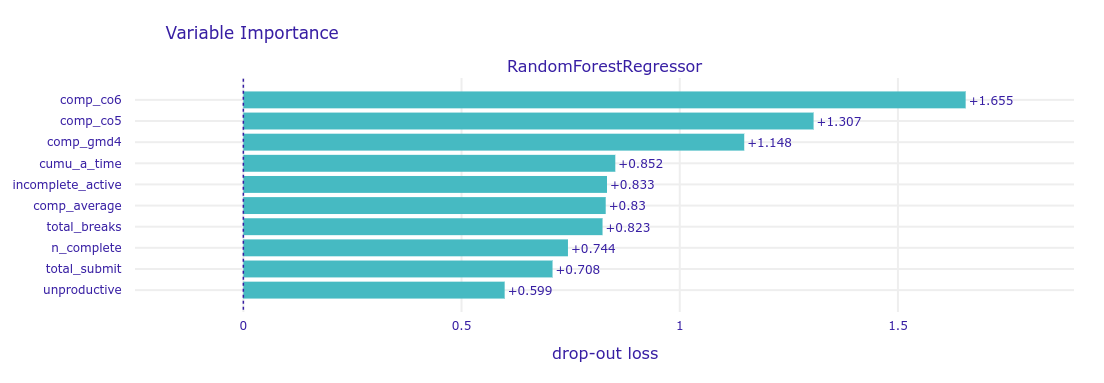

## gender_number

### where gender_number==0.0

**Mean Absolute Error:** 5.73 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,12,0.418277,"[-0.2, 0.8]",0.176001,0.811,0.28288


**R^2 Score:**

-0.10345645067133669

### where gender_number==1.0

**Mean Absolute Error:** 3.67 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,21,0.54941,"[0.15, 0.79]",0.009886,6.098,0.761827


**R^2 Score:**

0.23622774255788292

## hand_number

### where hand_number==0.0

**Mean Absolute Error:** 4.23 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,25,0.509903,"[0.14, 0.75]",0.009217,6.128,0.765304


**R^2 Score:**

0.24414632153273674

### where hand_number==1.0

**Mean Absolute Error:** 5.02 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,8,0.627451,"[-0.14, 0.92]",0.09584,1.431,0.412842


**R^2 Score:**

0.3652005346005345

In [36]:
run_regressor("rf", "sri", features, protecteds)

---

# rf sbst

Fitting 2 folds for each of 200 candidates, totalling 400 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimato

**Hyperparameters:**

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
0,600,10,2,sqrt,40,True


**Mean Absolute Error:** 5.57 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,34,0.344066,"[0.01, 0.61]",0.046317,1.434,0.524867


**R^2 Score:**

0.08883840030376644

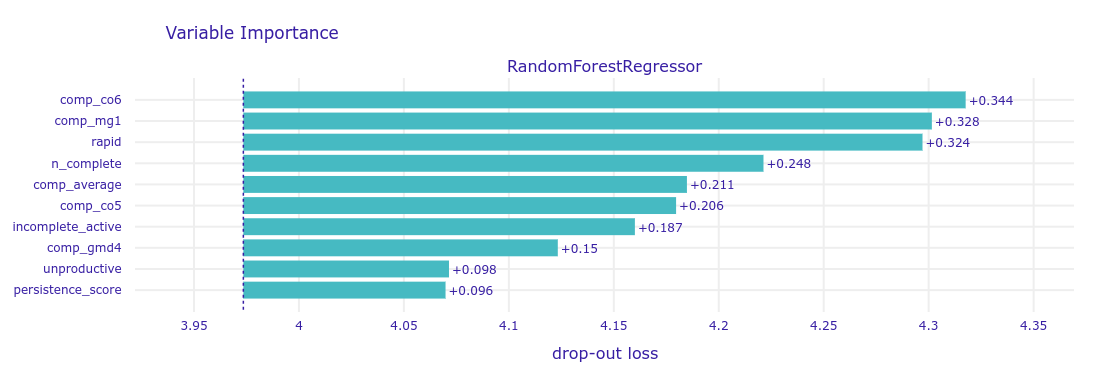

## gender_number

### where gender_number==0.0

**Mean Absolute Error:** 7.43 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,13,0.184765,"[-0.41, 0.67]",0.545647,0.403,0.092834


**R^2 Score:**

-0.13249695799504568

### where gender_number==1.0

**Mean Absolute Error:** 4.41 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,21,0.239983,"[-0.21, 0.61]",0.294725,0.453,0.184697


**R^2 Score:**

0.04774351000218746

## hand_number

### where hand_number==0.0

**Mean Absolute Error:** 5.78 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,26,0.356022,"[-0.04, 0.65]",0.074246,1.104,0.442332


**R^2 Score:**

0.09659267907929792

### where hand_number==1.0

**Mean Absolute Error:** 4.88 degrees.

**Pearson:**

,n,r,CI95%,p-val,BF10,power
pearson,8,0.249909,"[-0.55, 0.81]",0.550564,0.503,0.09212


**R^2 Score:**

-0.025627235722534225

In [45]:
run_regressor("rf", "sbst", features, protecteds)

In [15]:
# run_regressor("xgb", "sri", features, protecteds)

In [16]:
# run_regressor("xgb", "sbst", features, protecteds)